In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from z3 import *
import itertools
from IPython.display import Markdown, display,HTML,Image

### Puzzle as published 
https://www.janestreet.com/puzzles/kenken-concatenated-index/

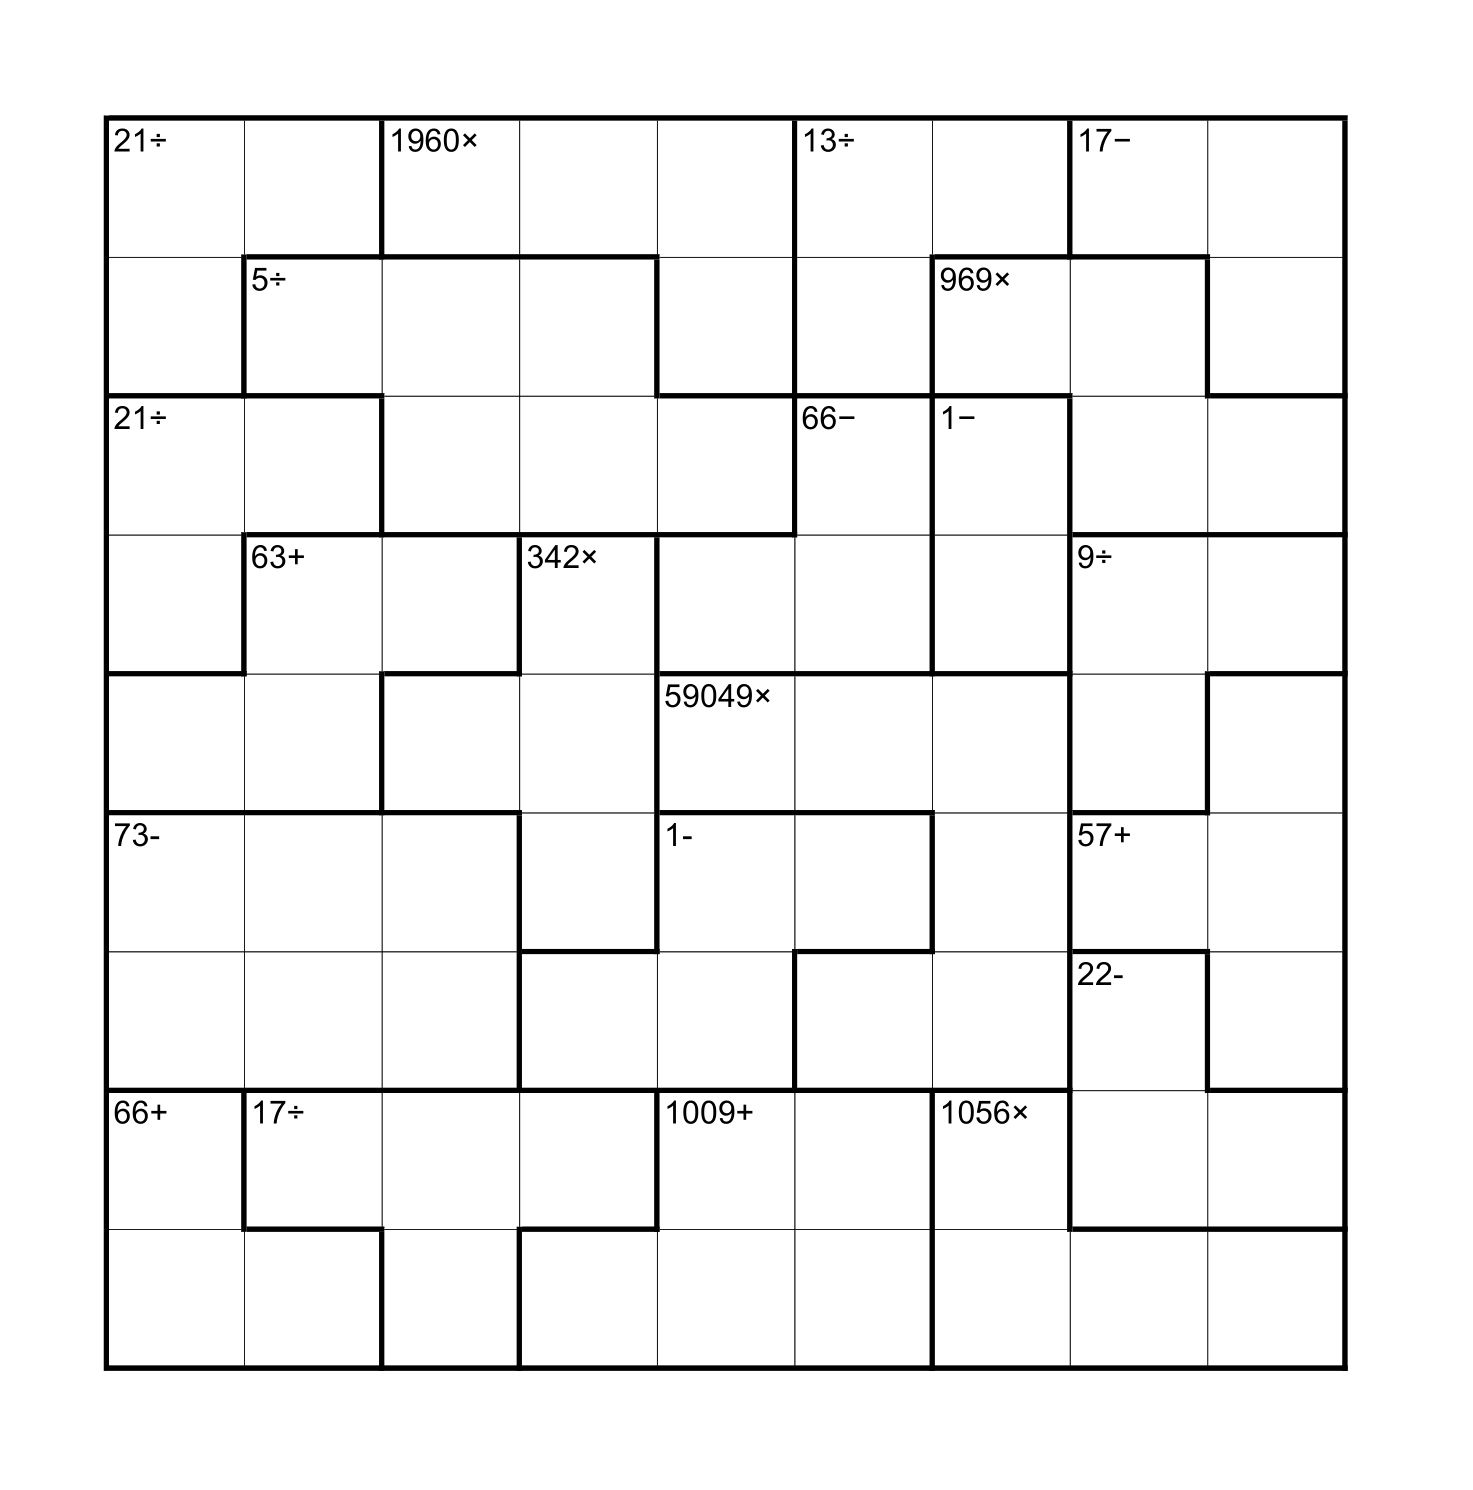

In [2]:
# Speed up by removing the divides and improving tactics. Plus a tidy up

url='https://www.janestreet.com/puzzles/kenken-concatenated-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))

display(HTML(str(soup.find_all('div', {'class' :'col-12'})[4])))
display(Image('https://www.janestreet.com/puzzles/may17_puzzle.png',width=250))

In [3]:
grid = np.array([[20, 20,  1,  1,  1,  2,  2,  3,  3],
                 [20,  4,  4,  4,  1,  2,  5,  5,  3],
                 [ 6,  6,  4,  4,  4,  7,  8,  5,  5],
                 [ 6,  9,  9, 10,  7,  7,  8, 11, 11],
                 [ 9,  9, 10, 10, 12, 12, 12, 11, 13],
                 [14, 14, 14, 10, 15, 15, 12, 13, 13],
                 [14, 14, 14, 15, 15, 12, 12, 16, 13],
                 [17, 18, 18, 18, 19, 19,  0, 16, 16],
                 [17, 17, 18, 19, 19, 19,  0,  0,  0]],dtype=int)


In [4]:
def counter(groups,solved):
    group_poss = []
    for i in range(21):
        group_poss.append([0])
    
    group = 0
    total =0
    for i,j in itertools.product(range(9),range(9)):  
        num = solved[i,j]
        if groups[i,j] == group:
            total *=10
            total += num
        else:
            group_poss[group].append(total)
            group = groups[i,j]
            total = num
    group_poss[group].append(total)
     
    prod = 0
    for i in range(21):
        #print(i,group_poss[i])
        prod +=max(group_poss[i])
        
    return prod

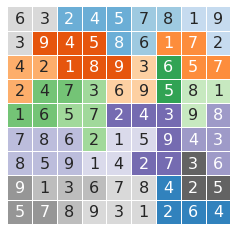

The sum of the squares is : 4,282
Solved in 0.5955 seconds


In [5]:
# Setup # 9x9 matrix of integer variables and solver #
start = time.time()
N= grid.shape[0]
s = Tactic("qffd").solver()
X = np.array(IntVector('x', N*N),dtype=object).reshape((N,N))   

# each cell contains a value in {1, ..., 9}
s += [And(e>0,e<=9) for _,e in np.ndenumerate(X)]

# each row contains a digit at most once
for n in range(N):
    s += Distinct([e for (i,j),e in np.ndenumerate(X) if i ==n])
    s += Distinct([e for (i,j),e in np.ndenumerate(X) if j ==n])
    
# Specific constraints 
def build(nums):
    return sum([e*10**i for i,e in enumerate(reversed(nums))])

s += build(X[0,:2]) == X[1,0] * 21
s += build(X[0,2:5]) * X[1,4] == 1960
s += build(X[0,5:7]) == X[1,5] * 13
s += build(X[0,7:9]) - X[1,8] == 17
s += Or(build(X[1,1:4]) * 5 == build(X[2,2:5]),
        build(X[1,1:4]) == build(X[2,2:5]*5))
s += build(X[1,6:8]) * build(X[2,7:9]) == 969 
s += build(X[2,:2]) == X[3,0] * 21
s += build(X[3,4:6]) - X[2,5] == 66
s += Or(X[2,6] - X[3,6] == 1,X[2,6] - X[3,6] == -1) 
s += build(X[3,1:3]) + build(X[4,:2]) == 63
s += X[3,3] * build(X[4,2:4]) * X[5,3] == 342
s += build(X[3,7:9]) == X[4,7]* 9
s += build(X[4,4:7]) * X[5,6] * build(X[6,5:7]) == 59049
s += Or(build(X[5,:3]) - build(X[6,:3]) == 73,
        build(X[5,:3]) - build(X[6,:3]) == -73)
s += Or(build(X[5,4:6]) - build(X[6,3:5]) == 1,
        build(X[5,4:6]) - build(X[6,3:5]) == -1,)
s += X[4,8] + build(X[5,7:9]) + X[6,8] == 57
s += build(X[7,7:9]) - X[6,7] == 22
s += build(X[8,:2]) + X[7,0] == 66      
s += build(X[7,1:4]) == X[8,2] * 17
s += build(X[8,3:6]) + build(X[7,4:6]) == 1009      
s += build(X[8,6:9]) * X[7,6] == 1056

# Solve and print 
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    r = evalu(X)
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    ax =sns.heatmap(grid,annot=r,cbar=False,cmap="tab20c",fmt="",linewidths=1,annot_kws={"size":16})
    ax.axis("off")
    plt.show()
    print("The sum of the squares is : {:,.0f}".format(counter(grid,np.array(r))))   
else:
    print("Failed")

print("Solved in {:.4f} seconds".format(time.time()-start))

### Solution as published 
https://www.janestreet.com/puzzles/kenken-concatenated-solution/

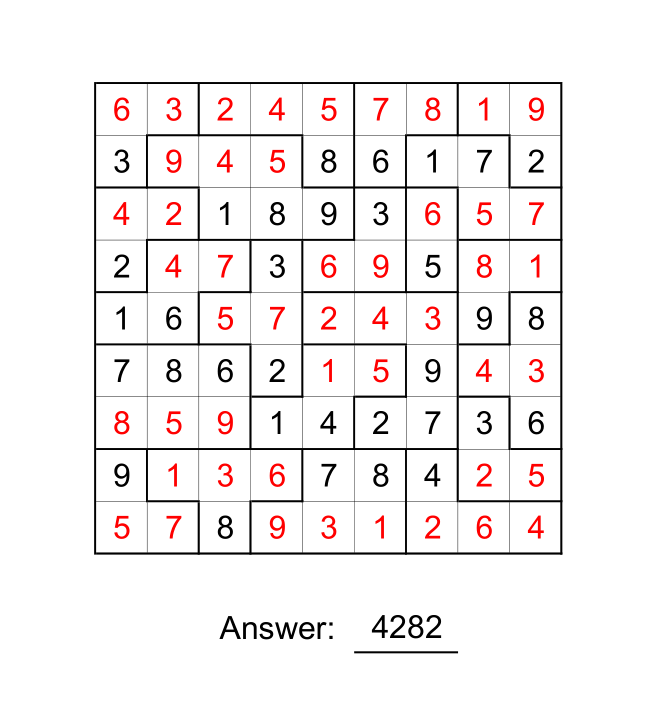

In [6]:
url='https://www.janestreet.com/puzzles/kenken-concatenated-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))

display(HTML(str(soup.find_all('div', {'class' :'col-12'})[4])))
display(Image('https://www.janestreet.com/puzzles/May17_solution.png',width=250))